In [1]:
!pip install -q --upgrade pip
!pip install -q --upgrade jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q tensorflow-datasets
!pip install -q git+https://www.github.com/google/neural-tangents

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.3/114.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [2]:
import jax
import numpy as np

from jax import jit
from jax import grad
from jax import random

import jax.numpy as jnp
from jax.nn import log_softmax
from jax.example_libraries import optimizers

import tensorflow_datasets as tfds

import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
W_0 = [-0.7645158 , -0.0250984 , -1.133804  , -0.03829474, -0.13075697,
          -0.11048132,  1.0224955 , -0.9789039 ,  0.81434107,  0.28093112]
b_0 = [-0.11460838,
         -0.3517475 ,
          0.12212043,
          0.47735927,
          0.34522718,
         -0.5399481 ,
         -0.16559786,
         -0.24302545,
          0.09792899,
          0.5944655 ]
W_1 = [-1.1232858 ,  1.0349628 ,  0.97679436, -0.18153423,  0.7232132 ,
           0.4670005 , -0.36788744,  0.2350446 , -0.3958354 ,  0.8658353 ]
b_1 = [-0.18262307]

In [4]:
def init_mlp_params(layer_widths, list):
    params = []

    # Allocate weights and biases (model parameters)
    # Notice: we're not using JAX's PRNG here - doesn't matter for this simple example
    a = 0
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        if a == 0:
          params.append(
            dict(weights=list[0],
                biases=list[1]))
          a = a + 1
        else:
          params.append(
            dict(weights=list[2],
                biases=list[3]))
    return params

# Instantiate a single input - single output, 3 layer (2 hidden layers) deep MLP
params = init_mlp_params([1, 10, 1], [jnp.array([W_0], dtype='float64'), jnp.array(b_0, dtype='float64'), jnp.array([W_1], dtype='float64').T, jnp.array(b_1, dtype='float64')])

# Another example of how we might use tree_map - verify that shapes make sense:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (10,), 'weights': (1, 10)}, {'biases': (1,), 'weights': (10, 1)}]

In [5]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)  # MSE loss

lr = 0.00001

@jit  # notice how we do jit only at the highest level - XLA will have plenty of space to optimize
def update(params, x, y):

    # Note that grads is a pytree with the same structure as params.
    # grad is one of the many JAX functions that has built-in support for pytrees!

    grads = jax.grad(loss_fn)(params, x, y)

    # Task: analyze grads and make sure it has the same structure as params

    # SGD update
    return jax.tree_util.tree_map(
        lambda p, g: p - lr * g, params, grads  # for every leaf i.e. for every param of MLP
    )

In [6]:
params

[{'weights': Array([[-0.7645158 , -0.0250984 , -1.133804  , -0.03829474, -0.13075697,
          -0.11048132,  1.0224955 , -0.9789039 ,  0.81434107,  0.28093112]],      dtype=float64),
  'biases': Array([-0.11460838, -0.3517475 ,  0.12212043,  0.47735927,  0.34522718,
         -0.5399481 , -0.16559786, -0.24302545,  0.09792899,  0.5944655 ],      dtype=float64)},
 {'weights': Array([[-1.1232858 ],
         [ 1.0349628 ],
         [ 0.97679436],
         [-0.18153423],
         [ 0.7232132 ],
         [ 0.4670005 ],
         [-0.36788744],
         [ 0.2350446 ],
         [-0.3958354 ],
         [ 0.8658353 ]], dtype=float64),
  'biases': Array([-0.18262307], dtype=float64)}]

In [7]:
X = jnp.array([[ 1.4229934 ],
       [-0.7694232 ],
       [ 0.18693154],
       [-1.8928823 ],
       [ 0.8390223 ],
       [-0.80786455],
       [-1.1990117 ],
       [ 1.7281239 ],
       [ 0.6514684 ],
       [-0.18889305],
       [-1.7007519 ],
       [ 0.4624187 ],
       [-1.4208488 ],
       [ 2.0488164 ],
       [ 0.18885063],
       [ 0.26335493],
       [-1.2319794 ],
       [ 0.57641345],
       [ 1.4143786 ],
       [-0.18824942],
       [ 0.6712429 ],
       [ 1.9626212 ],
       [-0.6380914 ],
       [ 1.6973408 ],
       [ 1.1379755 ],
       [-0.06424444],
       [ 0.03995398],
       [ 0.7607389 ],
       [ 1.5491706 ],
       [ 0.45916963],
       [-0.42302114],
       [-0.22891377],
       [-0.9554228 ],
       [-0.72487444],
       [-0.44829613],
       [-1.6084336 ],
       [-0.00515358],
       [-0.46755362],
       [-0.63108253],
       [ 1.4433128 ],
       [ 0.09611866],
       [ 0.1519512 ],
       [-0.21378434],
       [-0.3947631 ],
       [ 1.8151172 ],
       [ 1.3990598 ],
       [-0.38444638],
       [-0.45884144],
       [-0.02543407],
       [ 0.1947339 ],
       [ 1.2576802 ],
       [-0.49022987],
       [-0.48774967],
       [ 0.5709151 ],
       [-0.62209004],
       [ 1.1585314 ],
       [-0.61611164],
       [-0.853702  ],
       [-1.9548331 ],
       [ 0.09757172],
       [-0.7471279 ],
       [ 0.14180093],
       [-0.73419815],
       [ 1.3191959 ],
       [-0.5761279 ],
       [ 0.2514541 ],
       [ 0.79598933],
       [-0.5963267 ],
       [-0.28341734],
       [ 0.38109946],
       [-0.2282071 ],
       [-0.5496032 ],
       [ 0.33840123],
       [ 1.881508  ],
       [-0.1858809 ],
       [ 1.5156671 ],
       [-0.71115583],
       [-1.2660422 ],
       [-0.7562617 ],
       [-0.08545087],
       [ 0.27632588],
       [ 1.6856902 ],
       [-0.44601882],
       [ 2.587651  ],
       [ 0.78883994],
       [ 0.8980923 ],
       [ 2.0546176 ],
       [ 1.4392779 ],
       [ 0.826575  ],
       [-0.02757164],
       [-0.95617485],
       [-0.65805084],
       [ 0.3751643 ],
       [ 0.7270253 ],
       [ 0.28862196],
       [-0.55771255],
       [ 1.1139343 ],
       [-0.4713115 ],
       [-0.30672675],
       [-0.91346914]], dtype='float64')

In [8]:
y = jnp.array([[ -96.36676  ],
       [ -17.848995 ],
       [ -52.647736 ],
       [  20.776796 ],
       [ -72.78775  ],
       [ -15.545514 ],
       [  -3.3958688],
       [-106.27772  ],
       [ -67.76811  ],
       [ -38.206234 ],
       [  14.274464 ],
       [ -62.74348  ],
       [   5.592495 ],
       [-116.78298  ],
       [ -53.314274 ],
       [ -53.27179  ],
       [  -1.1411812],
       [ -62.970932 ],
       [ -94.354904 ],
       [ -38.586704 ],
       [ -68.538445 ],
       [-112.86392  ],
       [ -22.652624 ],
       [-102.99926  ],
       [ -83.839165 ],
       [ -42.152214 ],
       [ -44.903263 ],
       [ -70.885864 ],
       [ -97.29062  ],
       [ -57.776115 ],
       [ -32.12645  ],
       [ -36.544815 ],
       [ -10.839234 ],
       [ -19.714369 ],
       [ -27.709055 ],
       [  11.107928 ],
       [ -44.628773 ],
       [ -28.248579 ],
       [ -23.791153 ],
       [ -94.35395  ],
       [ -47.045208 ],
       [ -50.967876 ],
       [ -37.87078  ],
       [ -30.886461 ],
       [-109.433105 ],
       [ -95.02953  ],
       [ -31.650303 ],
       [ -28.934679 ],
       [ -43.025997 ],
       [ -53.057724 ],
       [ -87.71894  ],
       [ -27.471378 ],
       [ -29.154205 ],
       [ -64.24519  ],
       [ -22.715006 ],
       [ -83.91665  ],
       [ -25.051847 ],
       [ -16.129763 ],
       [  23.871988 ],
       [ -46.712833 ],
       [ -19.295914 ],
       [ -50.223335 ],
       [ -19.131683 ],
       [ -90.35635  ],
       [ -23.285646 ],
       [ -51.75896  ],
       [ -71.9968   ],
       [ -24.174744 ],
       [ -36.340866 ],
       [ -57.7881   ],
       [ -35.786766 ],
       [ -25.58188  ],
       [ -56.251522 ],
       [-111.275154 ],
       [ -39.119453 ],
       [ -99.110504 ],
       [ -19.99335  ],
       [  -0.8735297],
       [ -18.850683 ],
       [ -43.141254 ],
       [ -54.445007 ],
       [-104.783424 ],
       [ -28.28434  ],
       [-134.93835  ],
       [ -73.10167  ],
       [ -76.27928  ],
       [-117.71327  ],
       [ -96.39233  ],
       [ -73.58957  ],
       [ -44.99873  ],
       [ -12.710113 ],
       [ -21.779875 ],
       [ -58.46139  ],
       [ -69.609116 ],
       [ -55.20095  ],
       [ -25.23826  ],
       [ -82.964775 ],
       [ -28.140932 ],
       [ -33.79203  ],
       [ -11.98914  ]], dtype='float64')

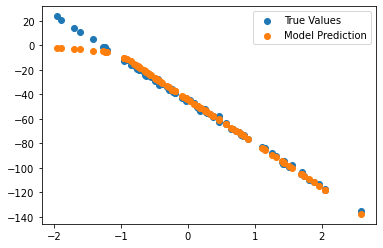

In [9]:
num_epochs = 5000
for _ in range(num_epochs):
    
    params = update(params, X, y)  
plt.scatter(X, y, label = 'True Values')
plt.scatter(X, forward(params,X), label='Model Prediction')
plt.legend();

In [ ]:
for pytree in params:
    leaves = jax.tree_leaves(pytree)  # handy little function
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

{'biases': Array([ 0.59508141, -0.3517475 , -0.2319476 ,  2.56100166, -0.07157149,
       -0.5399481 ,  3.08661607, -0.2985289 ,  3.92480537, -0.03676554],      dtype=float64), 'weights': Array([[-0.79592709, -0.0250984 , -1.07658782,  1.4317502 , -0.20116218,
        -0.11048132,  3.44207463, -0.97132167,  3.28820138, -0.11210699]],      dtype=float64)} has 2 leaves: [Array([ 0.59508141, -0.3517475 , -0.2319476 ,  2.56100166, -0.07157149,
       -0.5399481 ,  3.08661607, -0.2985289 ,  3.92480537, -0.03676554],      dtype=float64), Array([[-0.79592709, -0.0250984 , -1.07658782,  1.4317502 , -0.20116218,
        -0.11048132,  3.44207463, -0.97132167,  3.28820138, -0.11210699]],      dtype=float64)]
{'biases': Array([-2.05498672], dtype=float64), 'weights': Array([[-1.28514664],
       [ 1.0349628 ],
       [ 0.93085308],
       [-2.90042771],
       [ 0.65741565],
       [ 0.4670005 ],
       [-4.52080114],
       [ 0.26555046],
       [-5.06956488],
       [ 0.5752273 ]], dtype=float64

<ipython-input-34-5c95a4c0b908>:2: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  leaves = jax.tree_leaves(pytree)  # handy little function
